# <center> Analyse descriptive des données SIWIM </center>

In [1]:
#Loading packages
library(data.table)
library(xts)
library(zoo)
library(tseries)
library("TTR")
library(forecast)
library(ggplot2)

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'xts'

The following objects are masked from 'package:data.table':

    first, last

Warning message:
"package 'tseries' was built under R version 3.4.3"Warning message:
"package 'forecast' was built under R version 3.4.3"

#### Chargement des données

In [2]:
#Loading data
setwd("D:/Dropbox/Data science/Formation CEPE/Projet/GitHub/SiWIM-project")
siwim_data <- fread("2_Data/2_Retraitees/SiWIM_data_prepared.csv")

Read 183928 rows and 65 (of 65) columns from 0.065 GB file in 00:00:04


## 1. Quelques données...

In [3]:
head(siwim_data)

V1,Timestamp,Site_ID,Warning_flags,Lane,v,N,Subclass_ID,Axle_groups,WGV,...,M7,M8,M9,M10,M11,M12,M13,M14,M15,M16
1,2017-11-23 00:00:42,Normandie,00000000,droite,21.2228,5,113,113,288.3560,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,2017-11-23 00:21:31,Normandie,00000000,droite,20.5829,2,40,11,47.3393,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,2017-11-23 00:21:32,Normandie,00000000,droite,20.5829,2,20,11,16.2693,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,2017-11-23 00:24:14,Normandie,00000000,droite,22.6298,5,113,113,214.7090,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,2017-11-23 00:24:53,Normandie,00000000,droite,18.8756,5,113,113,315.0500,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,2017-11-23 00:30:35,Normandie,00000000,droite,20.4800,5,74,113,238.7490,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## 2. Un peu de refactoring...

In [4]:
#ID as number
siwim_data[, V1 := as.numeric(siwim_data$V1)]

# Refactor the lane
siwim_data[, Lane := factor(siwim_data$Lane, labels = c("droite", "gauche"))]

# Refactor classes data
cols <- c(
  "Warning_flags",
  "Site_ID",
  "Subclass_ID",
  "Axle_groups"
)

siwim_data[, (cols) := lapply(.SD, function(x) as.factor(x)), .SDcols=cols]
    
#Format date & time
siwim_data[, Timestamp := as.POSIXct(substr(siwim_data$Timestamp,1,19), format = '%Y-%m-%d %H:%M:%S')]

siwim_data[, Date := as.POSIXct(siwim_data$Date, format = '%Y-%m-%d')]

## 3. Résumé des données

In [5]:
summary(siwim_data)

       V1           Timestamp                        Site_ID      
 Min.   :     1   Min.   :2017-07-05 00:08:33   Normandie:183928  
 1st Qu.: 45983   1st Qu.:2017-08-02 11:36:19                     
 Median : 91965   Median :2017-09-06 17:12:22                     
 Mean   : 91965   Mean   :2017-09-12 14:28:02                     
 3rd Qu.:137946   3rd Qu.:2017-10-25 21:47:16                     
 Max.   :183928   Max.   :2017-11-23 18:59:49                     
                                                                  
  Warning_flags        Lane              v               N         
 00000000:130647   droite:167810   Min.   :10.01   Min.   : 2.000  
 00008000: 10159   gauche: 16118   1st Qu.:16.79   1st Qu.: 4.000  
 00800000: 10033                   Median :19.41   Median : 5.000  
 00000001: 10018                   Mean   :19.48   Mean   : 4.357  
 00000080:  9102                   3rd Qu.:22.02   3rd Qu.: 5.000  
 00000081:  4572                   Max.   :48.76   Max. 

In [6]:
str(siwim_data)

Classes 'data.table' and 'data.frame':	183928 obs. of  65 variables:
 $ V1                 : num  1 2 3 4 5 6 7 8 9 10 ...
 $ Timestamp          : POSIXct, format: "2017-11-23 00:00:42" "2017-11-23 00:21:31" ...
 $ Site_ID            : Factor w/ 1 level "Normandie": 1 1 1 1 1 1 1 1 1 1 ...
 $ Warning_flags      : Factor w/ 32 levels "00000000","00000001",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Lane               : Factor w/ 2 levels "droite","gauche": 1 1 1 1 1 1 1 1 1 1 ...
 $ v                  : num  21.2 20.6 20.6 22.6 18.9 ...
 $ N                  : int  5 2 2 5 5 5 5 6 5 5 ...
 $ Subclass_ID        : Factor w/ 72 levels "10","100","101",..: 9 32 25 9 9 52 9 65 9 9 ...
 $ Axle_groups        : Factor w/ 2211 levels "11","111","1111",..: 607 1 1 607 607 607 607 859 607 607 ...
 $ WGV                : num  288.4 47.3 16.3 214.7 315.1 ...
 $ W1                 : num  45.92 19.18 8.71 49.97 49.67 ...
 $ W2                 : num  85.62 28.16 7.56 79.55 88.53 ...
 $ W3                 : num  41.

***
## 4. Comparaison des vitesses moyennes en fonction de la voie (Lane)
***

### Test de student sur de la vitesse en fonction de la voie (Lane)

In [7]:
t.test(Vitesse ~ Lane, data = siwim_data)


	Welch Two Sample t-test

data:  Vitesse by Lane
t = 20.611, df = 19097, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.832829 2.218073
sample estimates:
mean in group droite mean in group gauche 
            70.30038             68.27493 


### Comparaison de la variance des groupes

In [8]:
var.test(Vitesse ~ Lane, data = siwim_data)


	F test to compare two variances

data:  Vitesse by Lane
F = 0.92612, num df = 167810, denom df = 16117, p-value = 2.847e-11
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.9050907 0.9474291
sample estimates:
ratio of variances 
         0.9261191 


### Normalité de l'échantillon

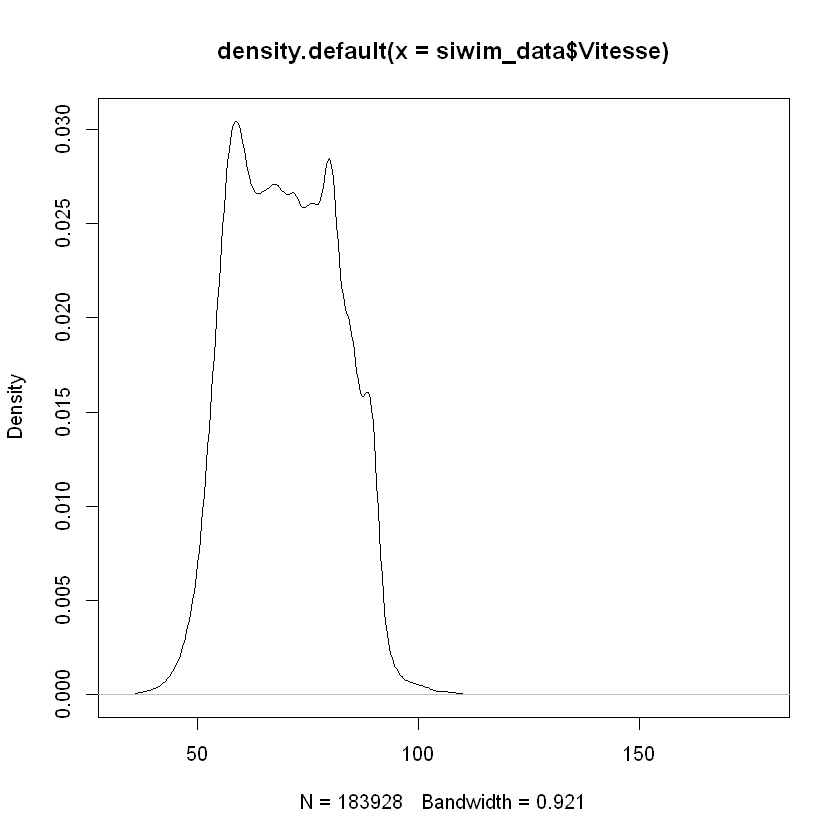

In [9]:
plot(density(siwim_data$Vitesse))

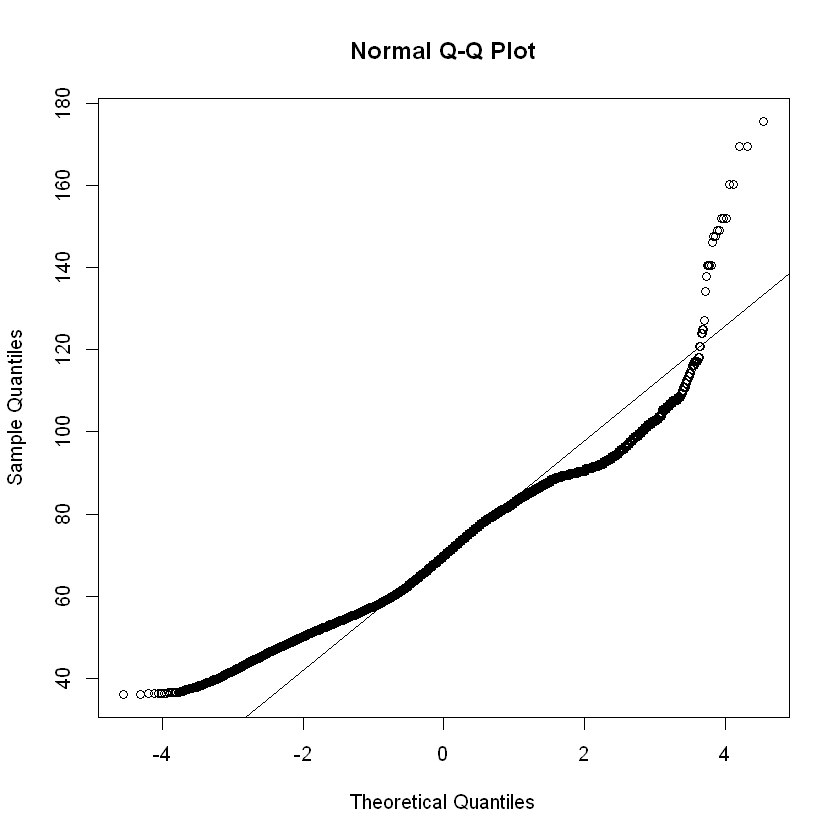

In [10]:
qqnorm(siwim_data$Vitesse); qqline(siwim_data$Vitesse)

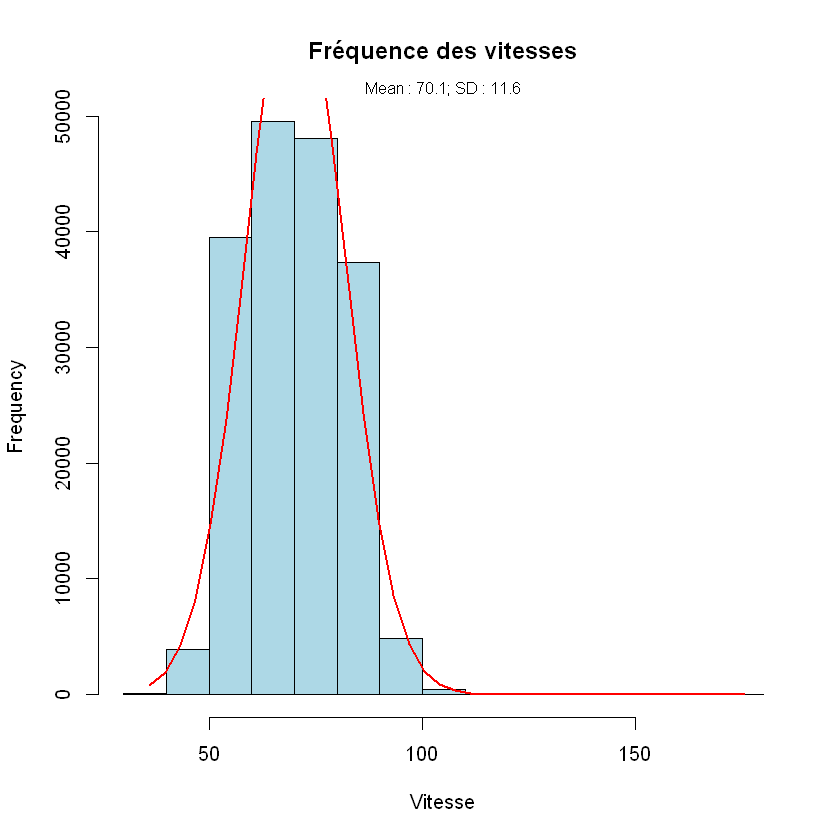

In [11]:
x <- siwim_data$Vitesse
h <- hist(x, col="lightblue", main="Fréquence des vitesses",  xlab="Vitesse")
m <- round(mean(x),1)
s <- round(sd(x),1)
mtext(paste0("Mean : ", m, "; SD : ", s), 
      side=3, cex=0.8)
# add normal curve
 xfit <- seq(min(x),max(x),length=40)
 yfit <- dnorm(xfit,mean=mean(x),sd=sd(x))
 yfit <- yfit*diff(h$mids[1:2])*length(x)
lines(xfit, yfit, col="red", lwd=2)

***
## 5. Correlation du nombre d'essieux et du poids total des camions
***

### Aperçu graphique

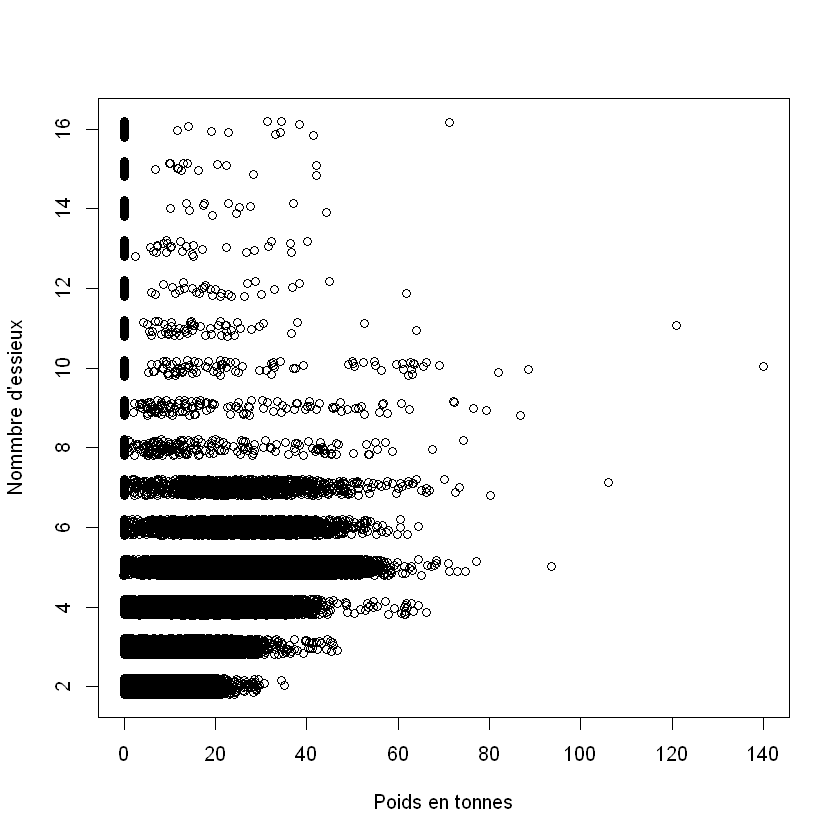

In [12]:
plot(jitter(siwim_data$MGV), jitter(siwim_data$N), ylab = "Nommbre d'essieux", xlab = "Poids en tonnes")

### Calcul de la corrélation et test de correlation de Pearson

In [13]:
cor(siwim_data$MGV,siwim_data$N,use="complete.obs")

[1] 0.2950818

In [14]:
cor.test(siwim_data$MGV, siwim_data$N)


	Pearson's product-moment correlation

data:  siwim_data$MGV and siwim_data$N
t = 132.45, df = 183930, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2909040 0.2992484
sample estimates:
      cor 
0.2950818 


### Test de normalité des variables

Poids en tonnes

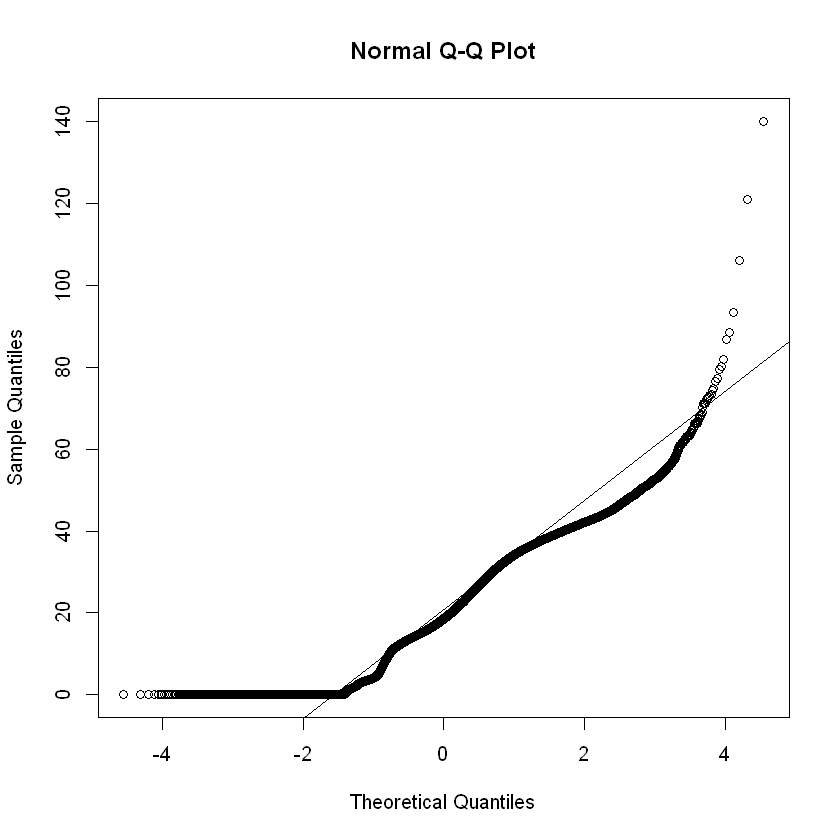

In [15]:
qqnorm(siwim_data$MGV); qqline(siwim_data$MGV)

Nombre d'essieux

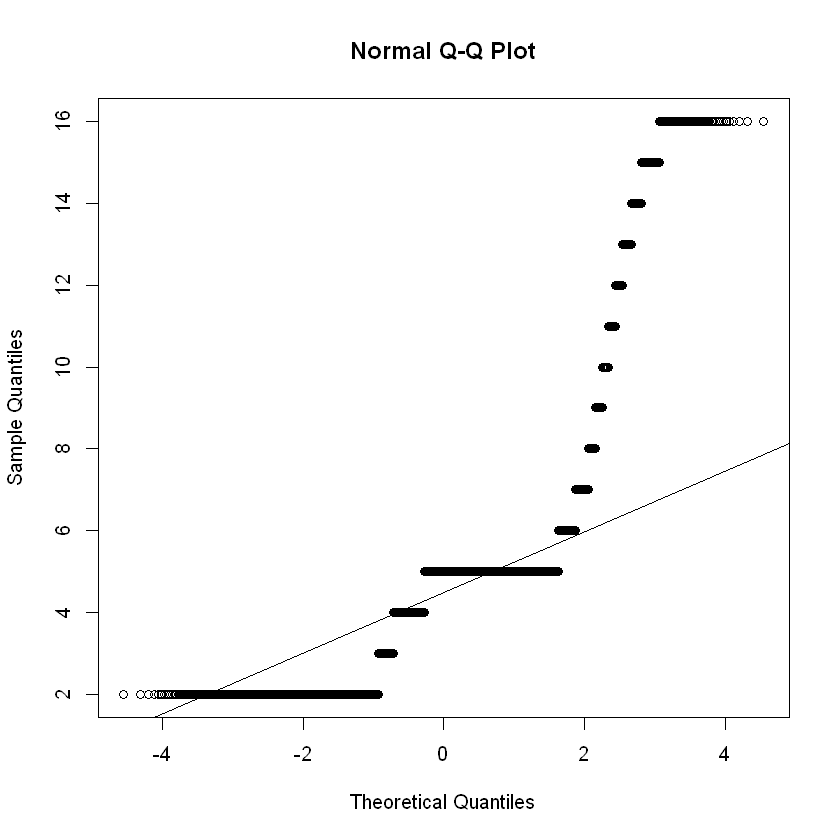

In [16]:
qqnorm(siwim_data$N); qqline(siwim_data$N)

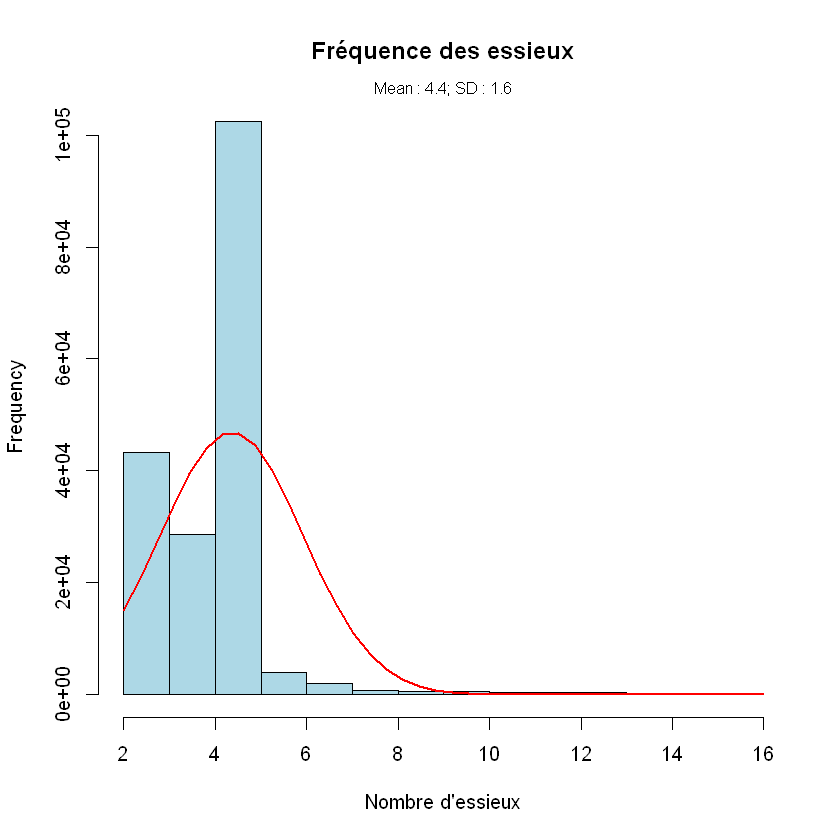

In [17]:
x <- siwim_data$N
h <- hist(x, col="lightblue", main="Fréquence des essieux",  xlab="Nombre d'essieux")
m <- round(mean(x),1)
s <- round(sd(x),1)
mtext(paste0("Mean : ", m, "; SD : ", s), 
      side=3, cex=0.8)
# add normal curve
 xfit <- seq(min(x),max(x),length=40)
 yfit <- dnorm(xfit,mean=mean(x),sd=sd(x))
 yfit <- yfit*diff(h$mids[1:2])*length(x)
lines(xfit, yfit, col="red", lwd=2)

### Test de correlation de Spearman

In [18]:
cor.test(siwim_data$MGV,siwim_data$N, method = "spearman")

Warning message in cor.test.default(siwim_data$MGV, siwim_data$N, method = "spearman"):
"Cannot compute exact p-value with ties"


	Spearman's rank correlation rho

data:  siwim_data$MGV and siwim_data$N
S = 5.6533e+14, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.4548586 


***
## 6. Premier modèle linéaire simple
***

In [19]:
model <- lm(Vitesse ~ MGV + Lane + total_axle_dist + T + N, data = siwim_data)
summary(model)


Call:
lm(formula = Vitesse ~ MGV + Lane + total_axle_dist + T + N, 
    data = siwim_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-45.147  -5.879   0.077   6.631  93.720 

Coefficients:
                  Estimate Std. Error  t value Pr(>|t|)    
(Intercept)     82.4547860  0.0709829 1161.615   <2e-16 ***
MGV             -0.4649763  0.0019762 -235.287   <2e-16 ***
Lanegauche      -3.3132118  0.0795636  -41.642   <2e-16 ***
total_axle_dist  0.4693661  0.0093522   50.188   <2e-16 ***
T               -0.0003326  0.0007165   -0.464    0.642    
N               -1.8679068  0.0328539  -56.855   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9.61 on 183922 degrees of freedom
Multiple R-squared:  0.3089,	Adjusted R-squared:  0.3089 
F-statistic: 1.644e+04 on 5 and 183922 DF,  p-value: < 2.2e-16


In [20]:
drop1(model,.~.,test = "F")

,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
<none>,NA,NA,16986716,832404.4,NA,NA
MGV,1,5.112971e+06,22099687,880799.7,5.536020e+04,0.0000000
Lane,1,1.601570e+05,17146872,834128.4,1.734084e+03,0.0000000
total_axle_dist,1,2.326323e+05,17219348,834904.2,2.518803e+03,0.0000000
T,1,1.990315e+01,16986735,832402.6,2.154994e-01,0.6424913
N,1,2.985472e+05,17285263,835606.9,3.232491e+03,0.0000000


***
## 7. Analyse des warning flags
***

### Proportion des warnings flags

In [7]:
tab <- prop.table(table(siwim_data$Warning_flags))
tab


    00000000     00000001     00000080     00000081     00000200     00000201 
7.103160e-01 5.446697e-02 4.948676e-02 2.485755e-02 2.424862e-02 3.909138e-03 
    00000800     00000801     00000880     00000881     00000a00     00000a01 
5.349920e-03 8.807794e-04 5.110695e-04 2.664086e-04 9.242747e-05 4.349528e-05 
    00008000     00008001     00008080     00008081     00008800     00008801 
5.523357e-02 3.550302e-03 2.288939e-03 3.099039e-04 2.718455e-04 4.893219e-05 
    00008880     00008881     00040000     00040001     00040a00     00800000 
2.718455e-05 5.436910e-06 4.349528e-05 4.349528e-05 5.436910e-06 5.454852e-02 
    00800001     00800200     00800201     00800800     00800801     00808000 
5.165065e-03 1.919229e-03 1.141751e-04 1.299422e-03 1.576704e-04 3.860206e-04 
    00808001     00808800 
1.141751e-04 3.805837e-05 

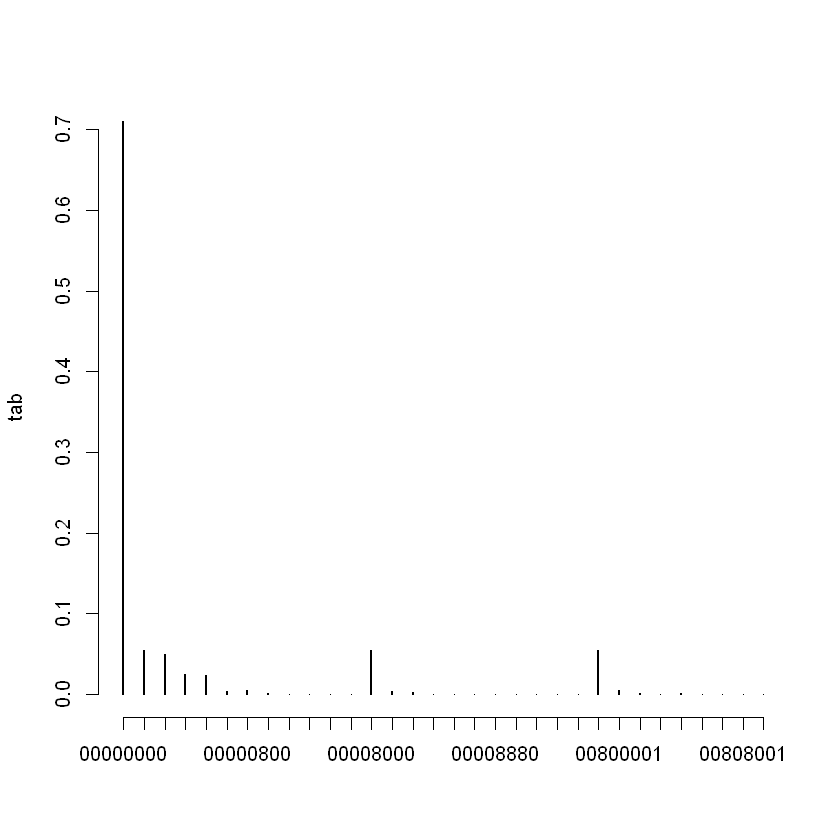

In [8]:
plot(tab)

In [9]:
siwim_data[Warning_flags == "00800000",c(mean(MGV),mean(N))]

[1] 35.070856  4.306887

In [10]:
siwim_data[Warning_flags == "00000000",c(mean(MGV),mean(N))]

[1] 21.644090  4.286222

## 8. Analyse des classes

In [7]:
table(siwim_data$Subclass_ID)


   10   100   101   102   103   104   110   111   113   114   115   116   120 
 1643  3117   455   390  4137   281  3222  2607 72716    67    30     6    26 
  121   122   123   124   130   131   132   133   134   136   140    20    21 
    2  1602    20    29    46    82     2    22   453    38 10661  3071   217 
   22    30    31    32    33    40    41    50    51    52    53    54    55 
   21  6698   324   163   247 11317  9320    51   756    35    75  1547    26 
   56    57    58    60    61    62    63    64    70    71    72    73    74 
 2295   909   407   820 19835  1242   216   148   158   331    27  1067 15576 
   75    76    77    78    79    80    81    82    83    84    85    90    91 
  606    17    74    31   152   188  2386   534   684   268     1    19   304 
   92    93    94    95    96    98    99 
   51    23     7     3    20     5     2 

In [12]:
table(siwim_data$Axle_groups)


             11             111            1111           11111          111111 
          31004            5368            2681             484             176 
        1111111        11111111       111111111      1111111111     11111111111 
             77              57              31              14               5 
   111111111111   1111111111111  11111111111111 111111111111111 111111111111121 
              7               6               1               1               1 
   111111111113     11111111112    111111111121   1111111111211     11111111113 
              1               7               1               1               1 
     1111111112     11111111121    111111111211    111111111222      1111111113 
              4               2               1               1               1 
    11111111131    111111111322     11111111141       111111112      1111111121 
              1               1               1               9               4 
    11111111211    11111111

### AFD pour les subclasses

In [7]:
maxN <- 16
axles_load <- paste("M", 1:maxN, sep = "")
axles_dist <- paste("A", 1:(maxN - 1), sep = "")

cols <- cols <- c(
  "Vitesse",
  "MGV",
  axles_load,
  "total_axle_dist",
  axles_dist,
  "T"
)

siwim_data_AFD <- siwim_data[,.SD, .SDcols =cols]

cov(siwim_data_AFD, use = "pairwise.complete.obs")

,Vitesse,MGV,M1,M2,M3,M4,M5,M6,M7,M8,...,A7,A8,A9,A10,A11,A12,A13,A14,A15,T
Vitesse,133.63497758,-77.13778617,-2.890781932,-21.30736059,-13.753397341,-17.562422827,-1.909839e+01,-7.392874679,-4.904971710,-0.926568318,...,2.6902620132,4.33561857,4.267474903,3.562322e+00,3.2994421709,3.45699777,3.013144819,3.121321594,5.922892779,-10.2631325
MGV,-77.13778617,153.33914323,16.268600159,43.96941621,23.253886534,27.725983415,3.128029e+01,27.510720889,19.090521344,9.134828695,...,-0.0695813566,-1.93757177,-1.625242870,-7.611338e-02,-0.1152181677,-0.94657382,-0.515392932,-0.478638194,-1.170112775,20.8997520
M1,-2.89078193,16.26860016,4.182147395,5.33694293,2.108263646,1.695790190,2.230571e+00,3.402954376,2.005464556,0.718855144,...,-0.0062256328,-0.15522155,-0.115210895,2.235922e-02,0.0064881554,-0.06500763,-0.022065655,-0.027509349,-0.072149462,5.1208973
M2,-21.30736059,43.96941621,5.336942926,15.49312088,6.186210528,7.814200443,8.783374e+00,4.602771163,3.058678208,1.163732793,...,0.0425491795,-0.31347649,-0.233216651,-1.277613e-02,0.0117179654,-0.08986169,-0.039514929,-0.055609724,-0.033507929,8.4747000
M3,-13.75339734,23.25388653,2.108263646,6.18621053,5.776258303,4.795516097,5.886103e+00,5.385506013,2.492944531,0.965688695,...,-0.0841160812,-0.17439687,-0.105187271,-1.651957e-02,0.0343542544,-0.09272881,-0.006726855,-0.044088537,-0.095340233,0.8399011
M4,-17.56242283,27.72598342,1.695790190,7.81420044,4.795516097,7.765990132,6.555386e+00,3.969222026,2.910274444,1.075298627,...,-0.0197760944,-0.26071197,-0.179501693,-9.568478e-03,-0.0087251451,-0.06597794,-0.018638190,-0.047744879,-0.071166451,4.3594418
M5,-19.09839320,31.28029479,2.230570998,8.78337350,5.886102815,6.555385555,7.810790e+00,4.214308232,2.340443517,0.998916360,...,-0.0412540203,-0.24508496,-0.195169206,-6.462019e-06,0.0330046823,-0.05366584,-0.045996082,-0.038098212,-0.011792590,2.9731456
M6,-7.39287468,27.51072089,3.402954376,4.60277116,5.385506013,3.969222026,4.214308e+00,4.558019956,2.040166902,0.828760383,...,-0.0698970812,-0.15197982,-0.101544495,-1.972404e-02,-0.0044456342,-0.03472304,-0.022492286,-0.021202020,-0.029850000,5.1315117
M7,-4.90497171,19.09052134,2.005464556,3.05867821,2.492944531,2.910274444,2.340444e+00,2.040166902,2.676860117,0.994107287,...,0.0996032176,-0.27700961,-0.189064470,1.026971e-02,0.0062505768,-0.06704301,-0.016817589,-0.015184065,-0.115952327,2.6789021
M8,-0.92656832,9.13482869,0.718855144,1.16373279,0.965688695,1.075298627,9.989164e-01,0.828760383,0.994107287,1.032044512,...,-0.0252100085,-0.09738474,-0.121499599,-2.876956e-02,-0.0109287912,-0.07229975,-0.009266551,0.001436466,-0.141504583,-0.8386471


In [8]:
cor(siwim_data_AFD, use = "pairwise.complete.obs")

,Vitesse,MGV,M1,M2,M3,M4,M5,M6,M7,M8,...,A7,A8,A9,A10,A11,A12,A13,A14,A15,T
Vitesse,1.000000000,-0.538865751,-0.122280045,-0.468274090,-0.506423890,-0.561632277,-6.260174e-01,-0.287794286,-0.240680428,-0.072244970,...,0.0834370360,0.136614686,0.134545995,1.159005e-01,0.1065231693,0.112389037,0.100368173,0.101242681,0.188628304,-0.028304716
MGV,-0.538865751,1.000000000,0.642427320,0.902100095,0.823488240,0.857177030,9.289395e-01,0.849476715,0.860741796,0.839599682,...,-0.0025438932,-0.073678372,-0.066638167,-4.276919e-03,-0.0072043513,-0.061194981,-0.033728110,-0.028510547,-0.055293319,0.053808831
M1,-0.122280045,0.642427320,1.000000000,0.663015126,0.469337171,0.342722978,4.475636e-01,0.655861348,0.642029817,0.643026517,...,-0.0022151601,-0.064321596,-0.054377753,1.583238e-02,0.0048362752,-0.060013392,-0.019523216,-0.021288801,-0.062514329,0.079833530
M2,-0.468274090,0.902100095,0.663015126,1.000000000,0.669829678,0.734164000,7.949551e-01,0.630781351,0.686358982,0.644250983,...,0.0093697310,-0.078000168,-0.069612642,-6.376922e-03,0.0076194652,-0.062319475,-0.027594232,-0.041651120,-0.034379149,0.068642615
M3,-0.506423890,0.823488240,0.469337171,0.669829678,1.000000000,0.726403672,8.618511e-01,0.818373362,0.708856972,0.713958543,...,-0.0247371121,-0.060169546,-0.042437703,-9.185227e-03,0.0243399284,-0.071736901,-0.004861836,-0.036004304,-0.069981749,0.011403787
M4,-0.561632277,0.857177030,0.342722978,0.734164000,0.726403672,1.000000000,8.238397e-01,0.714608458,0.745148626,0.709891777,...,-0.0051932317,-0.075019316,-0.058028944,-4.877437e-03,-0.0053213712,-0.044966766,-0.013836661,-0.039917773,-0.053299066,0.052298047
M5,-0.626017365,0.928939462,0.447563606,0.794955144,0.861851117,0.823839658,1.000000e+00,0.856316530,0.834581520,0.733862727,...,-0.0120555242,-0.080535826,-0.073343890,-3.854691e-06,0.0220269042,-0.042497863,-0.037899020,-0.035618833,-0.009145787,0.037425121
M6,-0.287794286,0.849476715,0.655861348,0.630781351,0.818373362,0.714608458,8.563165e-01,1.000000000,0.849321462,0.779197854,...,-0.0261403817,-0.064218413,-0.050104475,-1.343001e-02,-0.0038492759,-0.033918204,-0.022675774,-0.020535050,-0.023966584,0.046661320
M7,-0.240680428,0.860741796,0.642029817,0.686358982,0.708856972,0.745148626,8.345815e-01,0.849321462,1.000000000,0.794804337,...,0.0316763007,-0.089470439,-0.069124038,6.457498e-03,0.0044202430,-0.054060410,-0.014894379,-0.011588267,-0.081316051,0.028205658
M8,-0.072244970,0.839599682,0.643026517,0.644250983,0.713958543,0.709891777,7.338627e-01,0.779197854,0.794804337,1.000000000,...,-0.0097164737,-0.040809356,-0.058556375,-1.657479e-02,-0.0071182545,-0.047743647,-0.006250393,0.001017671,-0.078621011,-0.013460114


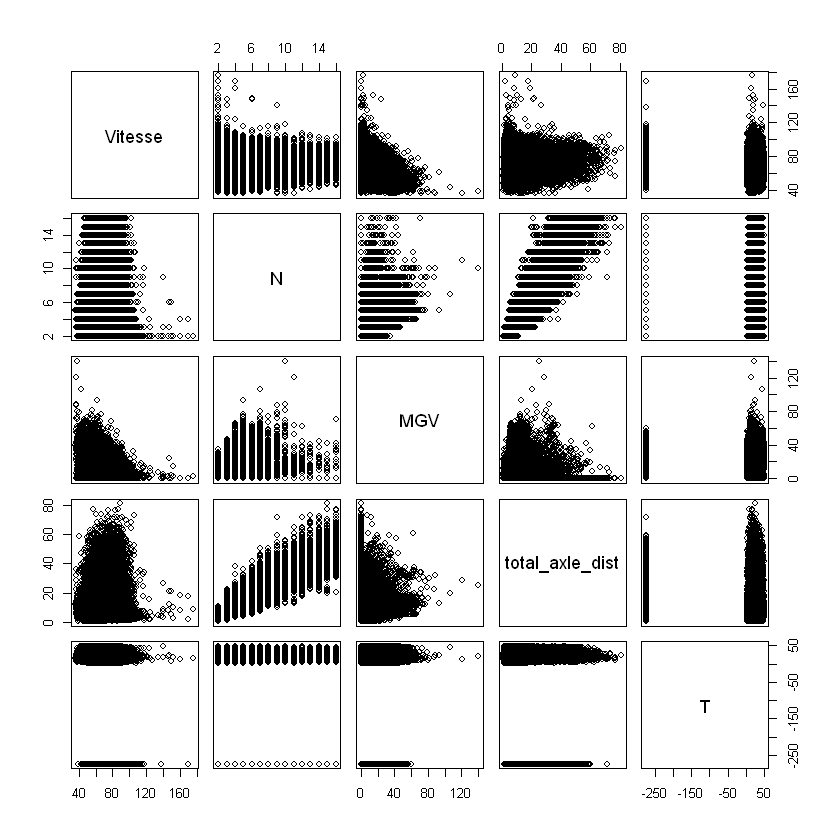

In [35]:
pairs(siwim_data[,.SD, .SDcols =c(
  "Vitesse",
  "N",
  "MGV",
  "total_axle_dist",
  "T"
)])

In [48]:
head(siwim_data$Subclass_ID)

[1] 113 40  20  113 113 74 
72 Levels: 10 100 101 102 103 104 110 111 113 114 115 116 120 121 122 ... 99

In [9]:
# Linear Discriminant Analysis with Jacknifed Prediction
library(MASS)
siwim_data_AFD2 <- siwim_data[,.SD, .SDcols =c(
  "Subclass_ID",
  "Vitesse",
  "N",
  "MGV",
  "total_axle_dist",
  "T"
)]
fit <- lda(Subclass_ID ~ ., data=siwim_data_AFD2,
   na.action="na.omit")
fit # show results 

Call:
lda(Subclass_ID ~ ., data = siwim_data_AFD2, na.action = "na.omit")

Prior probabilities of groups:
          10          100          101          102          103          104 
8.932843e-03 1.694685e-02 2.473794e-03 2.120395e-03 2.249250e-02 1.527772e-03 
         110          111          113          114          115          116 
1.751772e-02 1.417402e-02 3.953504e-01 3.642730e-04 1.631073e-04 3.262146e-05 
         120          121          122          123          124          130 
1.413597e-04 1.087382e-05 8.709930e-03 1.087382e-04 1.576704e-04 2.500979e-04 
         131          132          133          134          136          140 
4.458266e-04 1.087382e-05 1.196120e-04 2.462920e-03 2.066026e-04 5.796290e-02 
          20           21           22           30           31           32 
1.669675e-02 1.179809e-03 1.141751e-04 3.641642e-02 1.761559e-03 8.862163e-04 
          33           40           41           50           51           52 
1.342917e-03 6.152951e-02

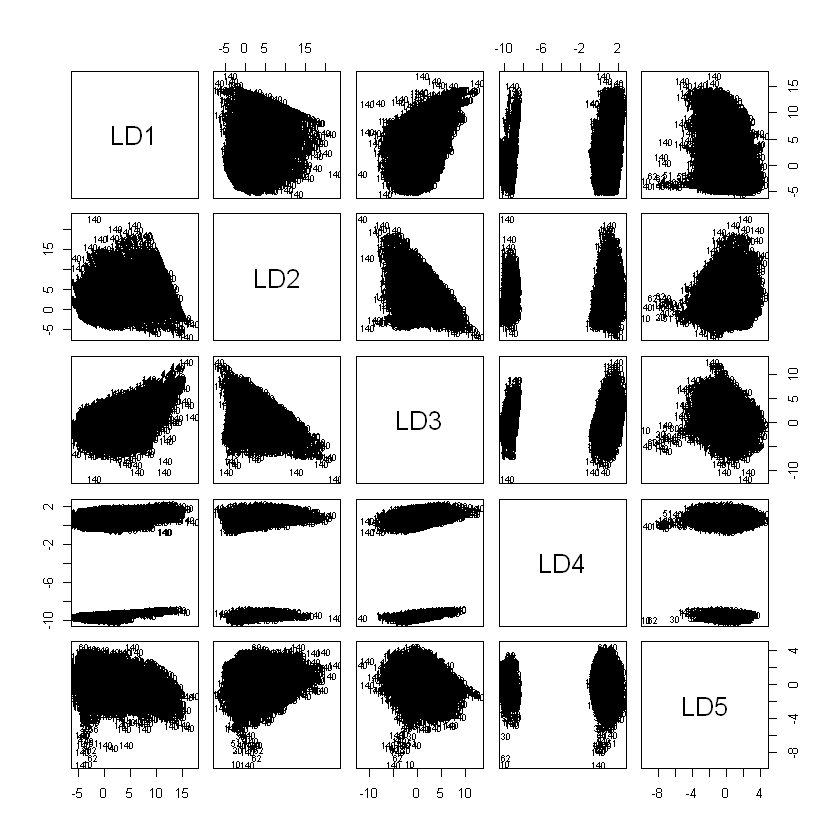

In [14]:
# Scatter plot using the 1st two discriminant dimensions
plot(fit) # fit from lda

In [15]:
fit2 <- lda(Subclass_ID ~ ., data=siwim_data_AFD2,
   na.action="na.omit",  CV = TRUE)
# Assess the accuracy of the prediction
# percent correct for each category of Subclass ID
ct <- table(siwim_data_AFD2$Subclass_ID, fit2$class)
diag(prop.table(ct, 1))
# total percent correct
sum(diag(prop.table(ct)))

10         100         101         102         103         104 
0.131466829 0.122553738 0.019780220 0.000000000 0.005076142 0.000000000 
        110         111         113         114         115         116 
0.014587213 0.000000000 0.995475549 0.000000000 0.000000000 0.000000000 
        120         121         122         123         124         130 
0.000000000 0.000000000 0.000000000 0.000000000 0.000000000 0.000000000 
        131         132         133         134         136         140 
0.000000000 1.000000000 0.000000000 0.000000000 0.000000000 0.374730325 
         20          21          22          30          31          32 
0.055682188 0.000000000 0.000000000 0.004031054 0.000000000 0.312883436 
         33          40          41          50          51          52 
1.000000000 0.953256163 0.891952790 0.000000000 0.000000000 0.000000000 
         53          54          55          56          57          58 
0.000000000 0.000000000 0.000000000 0.000000000 0.005500550 0.000000000 
         60          61          62          63          64          70 
0.000000000 0.979077388 0.099838969 0.000000000 0.000000000 0.000000000 
         71          72          73          74          75          76 
0.000000000 0.000000000 0.000000000 0.000000000 0.000000000 0.000000000 
         77          78          79          80          81          82 
0.000000000 0.000000000 0.105263158 0.000000000 0.000000000 0.000000000 
         83          84          85          90          91          92 
0.000000000 0.000000000         NaN 0.000000000 0.000000000 0.000000000 
         93          94          95          96          98          99 
0.000000000 0.000000000 0.000000000 0.000000000 0.000000000 0.000000000

[1] 0.6318866

## 9. Analyse temporelle

In [7]:
head(siwim_data[order(-Timestamp)])

V1,Timestamp,Site_ID,Warning_flags,Lane,v,N,Subclass_ID,Axle_groups,WGV,...,M7,M8,M9,M10,M11,M12,M13,M14,M15,M16
1966,2017-11-23 18:59:49,Normandie,00000000,droite,16.7869,5,113,113,374.8900,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1965,2017-11-23 18:59:28,Normandie,00000000,droite,25.2840,4,61,112,173.0630,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1964,2017-11-23 18:59:02,Normandie,00008000,droite,22.3825,5,113,113,80.7673,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1963,2017-11-23 18:58:28,Normandie,00000000,droite,19.7874,5,113,113,274.9940,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1962,2017-11-23 18:58:21,Normandie,00000000,droite,19.5048,5,113,113,332.3450,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1961,2017-11-23 18:57:49,Normandie,00000080,droite,21.7872,11,140,1112123,0.0000,...,0,0,0,0,0,NA,NA,NA,NA,NA


In [39]:
## Get days of the week for each point
siwim_data[, weekday := format(siwim_data$Timestamp, format = "%A")]

In [45]:
## New data table with number and weight by day and hour of the week
siwim_data_dayhour <- siwim_data[,.(.N, sum(MGV)), by = .(weekday, substr(Horaire,1,2))]
setnames(siwim_data_dayhour, ##Change 2 column names (invisible)
c("substr","N","V2"),
c("Hour","Number","Total_weight"))

In [46]:
## Refactor levels and set numeric values
siwim_data_dayhour[, weekday := factor(siwim_data_dayhour$weekday,levels= c("dimanche", "lundi", 
"mardi", "mercredi", "jeudi", "vendredi", "samedi"), ordered = TRUE)]
siwim_data_dayhour[, Hour := as.numeric(siwim_data_dayhour$Hour)]
head(siwim_data_dayhour)

weekday,Hour,Number,Total_weight
jeudi,0,203,4801.034
jeudi,1,149,3856.368
jeudi,2,211,5275.293
jeudi,3,346,8139.389
jeudi,4,451,9110.968
jeudi,5,828,17370.106


In [47]:
## Show ordered values in the week
siwim_data_dayhour <- siwim_data_dayhour[order(weekday, Hour)]
head(siwim_data_dayhour)

weekday,Hour,Number,Total_weight
dimanche,0,30,514.1544
dimanche,1,25,485.0922
dimanche,2,19,326.8657
dimanche,3,17,272.4908
dimanche,4,27,414.2462
dimanche,5,11,268.0125


In [48]:
## Concatenate dayas and hours
siwim_data_dayhour[, weekday_hour := paste(siwim_data_dayhour$weekday,siwim_data_dayhour$Hour)]
siwim_data_dayhour[, weekday_hour := factor(siwim_data_dayhour$weekday_hour, ordered = TRUE)]
#Set a good order for days and hours
siwim_data_dayhour$weekday_hour <- factor(siwim_data_dayhour$weekday_hour, levels(siwim_data_dayhour$weekday_hour)[siwim_data_dayhour$weekday_hour])
#siwim_data_dayhour[,c("weekday","Hour") := NULL]
head(siwim_data_dayhour)

weekday,Hour,Number,Total_weight,weekday_hour
dimanche,0,30,514.1544,dimanche 0
dimanche,1,25,485.0922,dimanche 1
dimanche,2,19,326.8657,dimanche 2
dimanche,3,17,272.4908,dimanche 3
dimanche,4,27,414.2462,dimanche 4
dimanche,5,11,268.0125,dimanche 5


In [49]:
## Show levels
levels(siwim_data_dayhour$weekday_hour)

[1] "dimanche 0"  "dimanche 1"  "dimanche 2"  "dimanche 3"  "dimanche 4" 
  [6] "dimanche 5"  "dimanche 6"  "dimanche 7"  "dimanche 8"  "dimanche 9" 
 [11] "dimanche 10" "dimanche 11" "dimanche 12" "dimanche 13" "dimanche 14"
 [16] "dimanche 15" "dimanche 16" "dimanche 17" "dimanche 18" "dimanche 19"
 [21] "dimanche 20" "dimanche 21" "dimanche 22" "dimanche 23" "lundi 0"    
 [26] "lundi 1"     "lundi 2"     "lundi 3"     "lundi 4"     "lundi 5"    
 [31] "lundi 6"     "lundi 7"     "lundi 8"     "lundi 9"     "lundi 10"   
 [36] "lundi 11"    "lundi 12"    "lundi 13"    "lundi 14"    "lundi 15"   
 [41] "lundi 16"    "lundi 17"    "lundi 18"    "lundi 19"    "lundi 20"   
 [46] "lundi 21"    "lundi 22"    "lundi 23"    "mardi 0"     "mardi 1"    
 [51] "mardi 2"     "mardi 3"     "mardi 4"     "mardi 5"     "mardi 6"    
 [56] "mardi 7"     "mardi 8"     "mardi 9"     "mardi 10"    "mardi 11"   
 [61] "mardi 12"    "mardi 13"    "mardi 14"    "mardi 15"    "mardi 16"   
 [66] "mardi 17"    "mardi 18"    "mardi 19"    "mardi 20"    "mardi 21"   
 [71] "mardi 22"    "mardi 23"    "mercredi 0"  "mercredi 1"  "mercredi 2" 
 [76] "mercredi 3"  "mercredi 4"  "mercredi 5"  "mercredi 6"  "mercredi 7" 
 [81] "mercredi 8"  "mercredi 9"  "mercredi 10" "mercredi 11" "mercredi 12"
 [86] "mercredi 13" "mercredi 14" "mercredi 15" "mercredi 16" "mercredi 17"
 [91] "mercredi 18" "mercredi 19" "mercredi 20" "mercredi 21" "mercredi 22"
 [96] "mercredi 23" "jeudi 0"     "jeudi 1"     "jeudi 2"     "jeudi 3"    
[101] "jeudi 4"     "jeudi 5"     "jeudi 6"     "jeudi 7"     "jeudi 8"    
[106] "jeudi 9"     "jeudi 10"    "jeudi 11"    "jeudi 12"    "jeudi 13"   
[111] "jeudi 14"    "jeudi 15"    "jeudi 16"    "jeudi 17"    "jeudi 18"   
[116] "jeudi 19"    "jeudi 20"    "jeudi 21"    "jeudi 22"    "jeudi 23"   
[121] "vendredi 0"  "vendredi 1"  "vendredi 2"  "vendredi 3"  "vendredi 4" 
[126] "vendredi 5"  "vendredi 6"  "vendredi 7"  "vendredi 8"  "vendredi 9" 
[131] "vendredi 10" "vendredi 11" "vendredi 12" "vendredi 13" "vendredi 14"
[136] "vendredi 15" "vendredi 16" "vendredi 17" "vendredi 18" "vendredi 19"
[141] "vendredi 20" "vendredi 21" "vendredi 22" "vendredi 23" "samedi 0"   
[146] "samedi 1"    "samedi 2"    "samedi 3"    "samedi 4"    "samedi 5"   
[151] "samedi 6"    "samedi 7"    "samedi 8"    "samedi 9"    "samedi 10"  
[156] "samedi 11"   "samedi 12"   "samedi 13"   "samedi 14"   "samedi 15"  
[161] "samedi 16"   "samedi 17"   "samedi 18"   "samedi 19"   "samedi 20"  
[166] "samedi 21"   "samedi 22"   "samedi 23"

### Plot total frequencies of trucks within a week

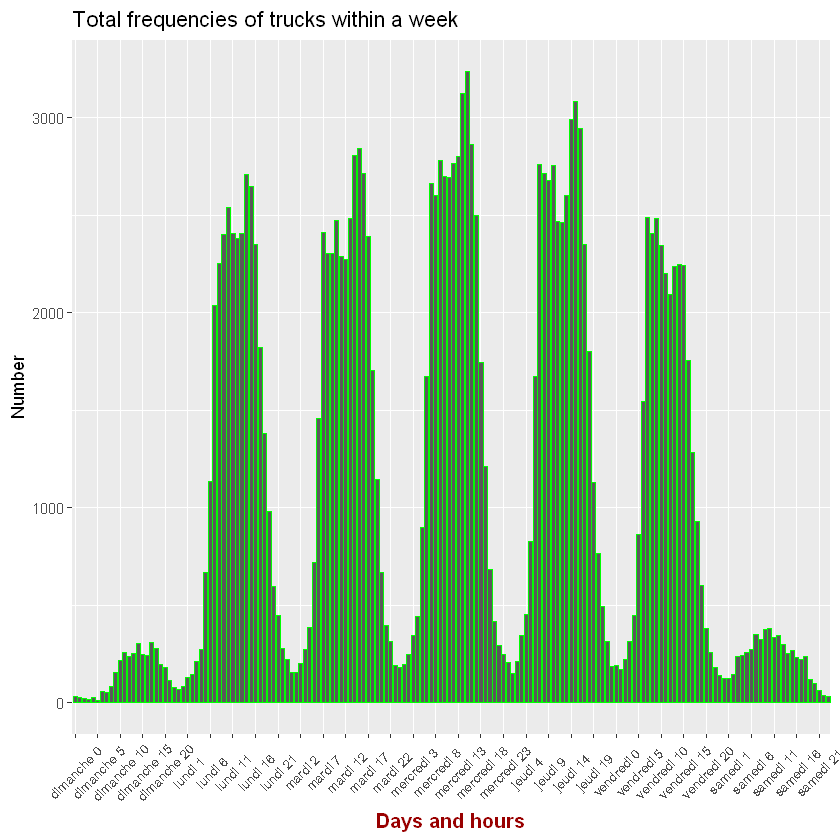

In [51]:
ggplot(siwim_data_dayhour) +
  aes(x = weekday_hour , y = Number) +
  geom_col(colour = "green")+
   theme(axis.title.x = element_text(face="bold", colour="#990000", size=12),
           axis.text.x  = element_text(angle=45, vjust=0.5, size=8)) +
    scale_x_discrete(breaks = function(x) x[seq(1, length(x), by = 5)]) +
        labs(title = "Total frequencies of trucks within a week", x = "Days and hours")

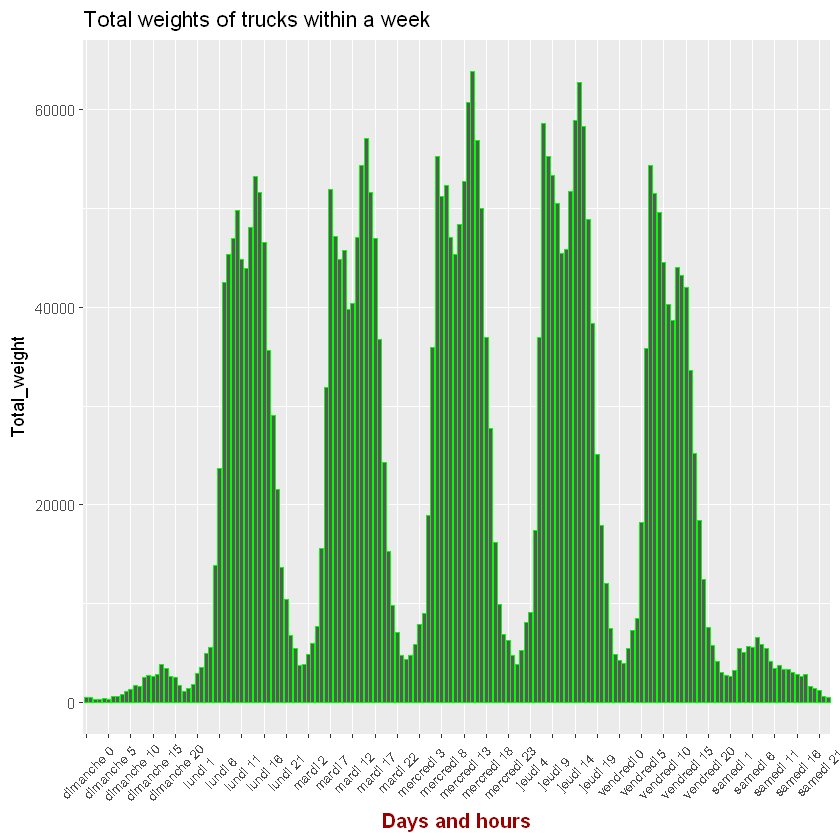

In [52]:
ggplot(siwim_data_dayhour) +
  aes(x = weekday_hour , y = Total_weight) +
  geom_col(colour = "green")+
   theme(axis.title.x = element_text(face="bold", colour="#990000", size=12),
           axis.text.x  = element_text(angle=45, vjust=0.5, size=8)) +
    scale_x_discrete(breaks = function(x) x[seq(1, length(x), by = 5)]) +
        labs(title = "Total weights of trucks within a week", x = "Days and hours")

In [7]:
siwim_data_agg <- siwim_data[,.(.N, sum(MGV)), by = Timestamp]

In [8]:
setnames(siwim_data_agg, ##Change 2 column names (invisible)
c("N","V2"),
c("Number","Total_weight"))

In [9]:
head(siwim_data_agg[order(-Timestamp)])

Timestamp,Number,Total_weight
2017-11-23 18:59:49,1,38.21509
2017-11-23 18:59:28,1,17.64149
2017-11-23 18:59:02,1,8.23316
2017-11-23 18:58:28,1,28.03201
2017-11-23 18:58:21,1,33.87819
2017-11-23 18:57:49,1,0.00000


In [56]:
siwim_data_agg[Number > 1]

Timestamp,Number,Total_weight
2017-11-23 05:47:07,2,17.1760449
2017-11-23 06:35:31,2,45.0232416
2017-11-23 07:17:18,2,27.5077472
2017-11-23 08:18:40,2,12.3952090
2017-11-23 08:18:42,2,0.0000000
2017-11-23 08:18:46,2,1.4756167
2017-11-23 08:45:49,2,0.7038634
2017-11-23 08:55:21,2,1.3172069
2017-11-23 08:59:50,2,9.4080224
2017-11-23 09:07:15,2,48.9082569


In [10]:
siwim_data.ts <- xts(x=cbind(siwim_data_agg$Total_weight,siwim_data_agg$Number), order.by = siwim_data_agg$Timestamp)

In [11]:
class(siwim_data.ts)

[1] "xts" "zoo"

In [12]:
head(coredata(siwim_data.ts))

38.775740,1
0.000000,1
15.325690,1
13.686440,1
3.512304,1
41.906930,1


In [13]:
head(index(siwim_data.ts))

[1] "2017-07-05 00:08:33 CEST" "2017-07-05 00:08:45 CEST"
[3] "2017-07-05 00:09:58 CEST" "2017-07-05 00:12:46 CEST"
[5] "2017-07-05 00:28:57 CEST" "2017-07-05 00:33:02 CEST"

In [40]:
ep1 <- endpoints(siwim_data.ts,on="days")
siwim_data.ts.days <- period.apply(siwim_data.ts[,2],INDEX=ep1,FUN=sum)
head(siwim_data.ts.days)

                    [,1]
2017-07-05 23:51:16 2852
2017-07-06 23:59:10 2372
2017-07-07 23:53:23 1895
2017-07-08 23:50:02  397
2017-07-09 23:27:28  280
2017-07-10 23:58:09 2086

In [41]:
start(siwim_data.ts)

[1] "2017-07-05 00:08:33 CEST"

In [42]:
end(siwim_data.ts)

[1] "2017-11-23 18:59:49 CET"

In [48]:
index(siwim_data.ts.days) <- as.Date(trunc(index(siwim_data.ts.days),"days"))
head(siwim_data.ts.days)

           [,1]
2017-07-05 2852
2017-07-06 2372
2017-07-07 1895
2017-07-08  397
2017-07-09  280
2017-07-10 2086

In [12]:
?auto.arima

In [80]:
fitting <- auto.arima(siwim_data.ts[,2])#, method = "ML")

In [81]:
fitting

Series: siwim_data.ts[, 2] 
ARIMA(5,1,0) 

Coefficients:
          ar1      ar2      ar3      ar4      ar5
      -0.8194  -0.6503  -0.4869  -0.3260  -0.1658
s.e.   0.0023   0.0029   0.0031   0.0029   0.0023

sigma^2 estimated as 0.00982:  log likelihood=162834.5
AIC=-325656.9   AICc=-325656.9   BIC=-325596.2

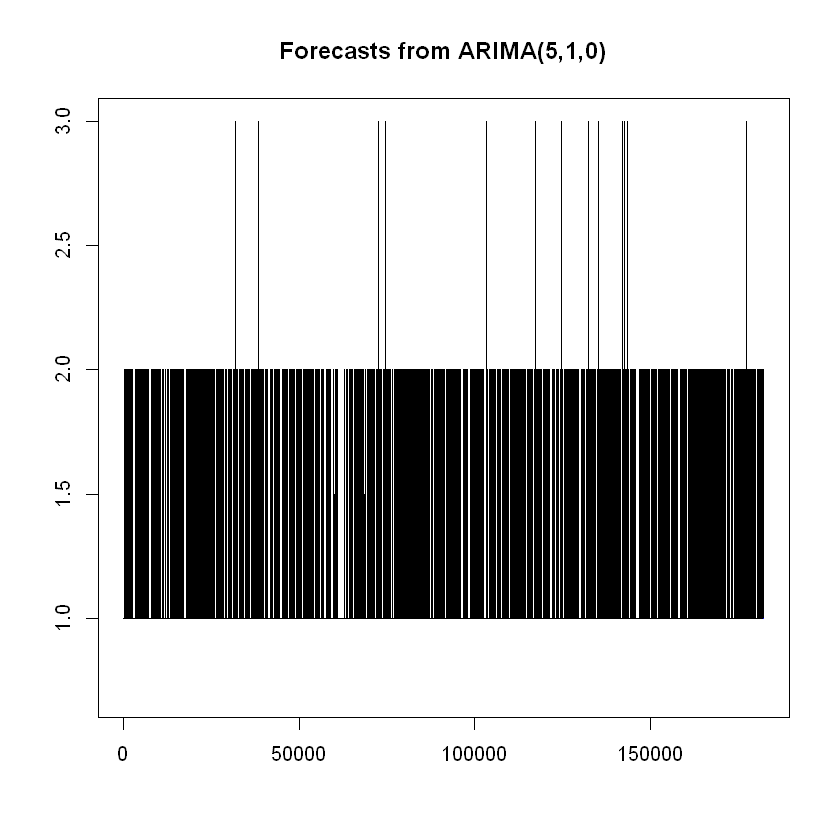

In [82]:
plot(forecast(fitting, h=20))

In [49]:
siwim_data.ts.days["2017-09/2017-10"]

           [,1]
2017-09-01 2014
2017-09-02  406
2017-09-03  242
2017-09-04 2025
2017-09-05 2144
2017-09-06 2149
2017-09-07 2268
2017-09-08 2001
2017-09-09  408
2017-09-10  184
2017-09-11  175
2017-09-12    3
2017-09-13    3
2017-09-14    3
2017-09-20 1555
2017-09-21 2155
2017-09-22 2131
2017-09-23  384
2017-09-24  245
2017-09-25 2173
2017-09-26 2300
2017-09-27 2397
2017-09-28 2387
2017-09-29 2010
2017-09-30  363
2017-10-01  170
2017-10-02 2048
2017-10-03 2399
2017-10-04 2345
2017-10-05  544
2017-10-17 1087
2017-10-18 2320
2017-10-19 2232
2017-10-20 2081
2017-10-21  320
2017-10-22  115
2017-10-23 2189
2017-10-24 2383
2017-10-25 2273
2017-10-26 2414
2017-10-27 2180
2017-10-28  312
2017-10-29  177
2017-10-30 2206
2017-10-31 2211

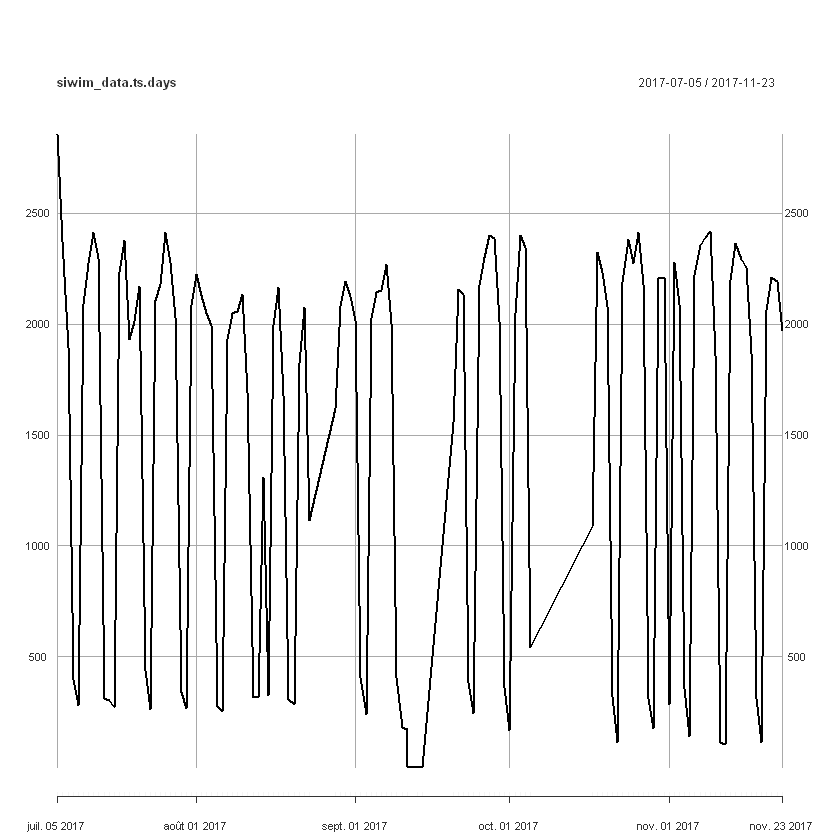

In [24]:
plot.xts(siwim_data.ts.days)

In [50]:
start_date <- start(siwim_data.ts.days)
as.POSIXlt(start_date)$mday
ts(siwim_data.ts.days, frequency = 7)

[1] 5

Time Series:
Start = c(1, 1) 
End = c(18, 3) 
Frequency = 7 
       Series 1
  [1,]     2852
  [2,]     2372
  [3,]     1895
  [4,]      397
  [5,]      280
  [6,]     2086
  [7,]     2271
  [8,]     2412
  [9,]     2295
 [10,]      312
 [11,]      303
 [12,]      272
 [13,]     2233
 [14,]     2375
 [15,]     1931
 [16,]     2013
 [17,]     2170
 [18,]      438
 [19,]      262
 [20,]     2106
 [21,]     2178
 [22,]     2411
 [23,]     2278
 [24,]     2029
 [25,]      339
 [26,]      268
 [27,]     2082
 [28,]     2221
 [29,]     2127
 [30,]     2046
 [31,]     1994
 [32,]      275
 [33,]      254
 [34,]     1931
 [35,]     2046
 [36,]     2055
 [37,]     2135
 [38,]     1692
 [39,]      318
 [40,]      318
 [41,]     1308
 [42,]      326
 [43,]     1993
 [44,]     2164
 [45,]     1680
 [46,]      308
 [47,]      285
 [48,]     1820
 [49,]     2076
 [50,]     1113
 [51,]     1619
 [52,]     2079
 [53,]     2192
 [54,]     2123
 [55,]     2014
 [56,]      406
 [57,]      242
 [58,]     

### Decomposing Non-Seasonal Data

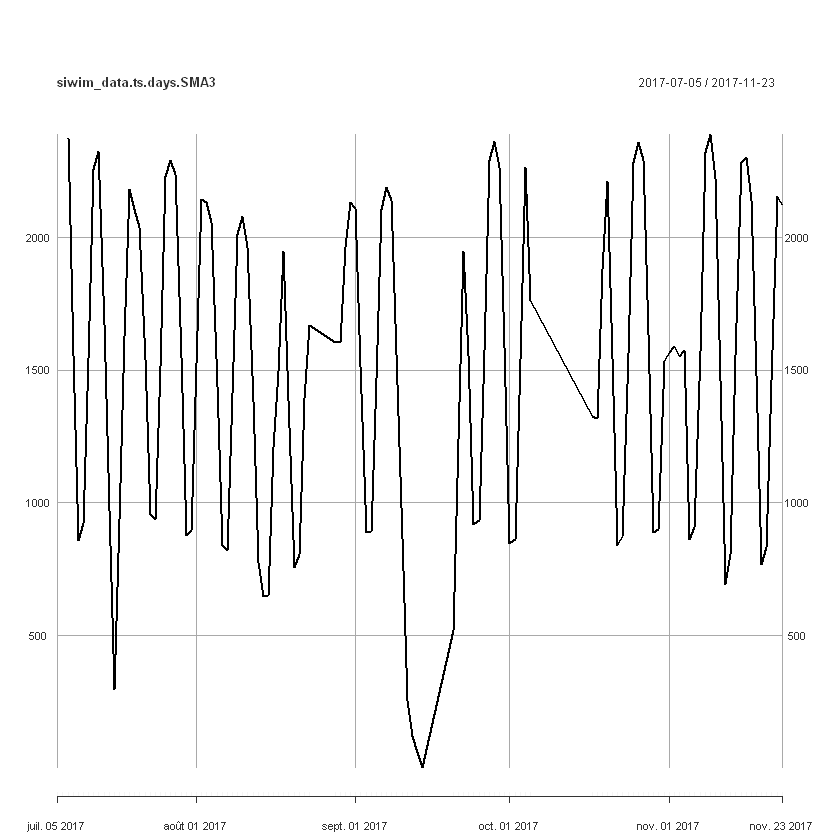

In [51]:
## Compute Simple moving average for 3
siwim_data.ts.days.SMA3 <- SMA(siwim_data.ts.days,n = 3)
plot.xts(siwim_data.ts.days.SMA3)

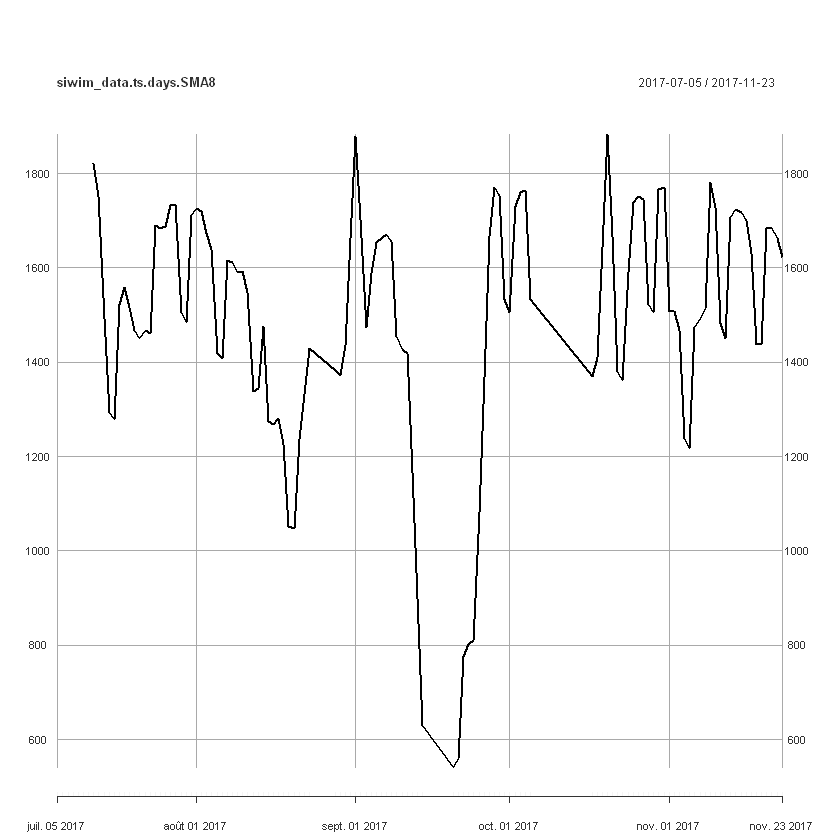

In [52]:
siwim_data.ts.days.SMA8 <- SMA(siwim_data.ts.days,n = 8)
plot.xts(siwim_data.ts.days.SMA8)

### Decomposing Seasonal Data

In [53]:
periodicity(siwim_data.ts.days)
start(siwim_data.ts.days)
end(siwim_data.ts.days)

Daily periodicity from 2017-07-05 to 2017-11-23 

[1] "2017-07-05"

[1] "2017-11-23"

In [136]:
?HoltWinters

In [67]:
ts(siwim_data.ts.days, start = c(5,7), frequency = 30)

Time Series:
Start = c(5, 7) 
End = c(9, 8) 
Frequency = 30 
       Series 1
  [1,]     2852
  [2,]     2372
  [3,]     1895
  [4,]      397
  [5,]      280
  [6,]     2086
  [7,]     2271
  [8,]     2412
  [9,]     2295
 [10,]      312
 [11,]      303
 [12,]      272
 [13,]     2233
 [14,]     2375
 [15,]     1931
 [16,]     2013
 [17,]     2170
 [18,]      438
 [19,]      262
 [20,]     2106
 [21,]     2178
 [22,]     2411
 [23,]     2278
 [24,]     2029
 [25,]      339
 [26,]      268
 [27,]     2082
 [28,]     2221
 [29,]     2127
 [30,]     2046
 [31,]     1994
 [32,]      275
 [33,]      254
 [34,]     1931
 [35,]     2046
 [36,]     2055
 [37,]     2135
 [38,]     1692
 [39,]      318
 [40,]      318
 [41,]     1308
 [42,]      326
 [43,]     1993
 [44,]     2164
 [45,]     1680
 [46,]      308
 [47,]      285
 [48,]     1820
 [49,]     2076
 [50,]     1113
 [51,]     1619
 [52,]     2079
 [53,]     2192
 [54,]     2123
 [55,]     2014
 [56,]      406
 [57,]      242
 [58,]     

In [30]:
ts(coredata(siwim_data.ts.days), start = start(siwim_data.ts.days), 
                                              end = end(siwim_data.ts.days), frequency = 7)

Time Series:
Start = c(17352, 1) 
End = c(17493, 1) 
Frequency = 7 
  [1] 2852 2372 1895  397  280 2086 2271 2412 2295  312  303  272 2233 2375 1931
 [16] 2013 2170  438  262 2106 2178 2411 2278 2029  339  268 2082 2221 2127 2046
 [31] 1994  275  254 1931 2046 2055 2135 1692  318  318 1308  326 1993 2164 1680
 [46]  308  285 1820 2076 1113 1619 2079 2192 2123 2014  406  242 2025 2144 2149
 [61] 2268 2001  408  184  175    3    3    3 1555 2155 2131  384  245 2173 2300
 [76] 2397 2387 2010  363  170 2048 2399 2345  544 1087 2320 2232 2081  320  115
 [91] 2189 2383 2273 2414 2180  312  177 2206 2211  285 2277 2088  359  142 2219
[106] 2354 2391 2416 1859  114  104 2195 2363 2291 2255 1869  315  114 2062 2209
[121] 2192 1966 2852 2372 1895  397  280 2086 2271 2412 2295  312  303  272 2233
[136] 2375 1931 2013 2170  438  262 2106 2178 2411 2278 2029  339  268 2082 2221
[151] 2127 2046 1994  275  254 1931 2046 2055 2135 1692  318  318 1308  326 1993
[166] 2164 1680  308  285 1820 2076 1113 

In [55]:
siwim_data.ts.days.components <- decompose(siwim_data.ts.days)

ERROR: Error in decompose(siwim_data.ts.days): time series has no or less than 2 periods


No seasonal component

### Simple exponential smoothing

In [56]:
siwim_data.ts.ses <- HoltWinters(siwim_data.ts.days ,beta = FALSE, 
                                       gamma = FALSE)
siwim_data.ts.ses

Holt-Winters exponential smoothing without trend and without seasonal component.

Call:
HoltWinters(x = siwim_data.ts.days, beta = FALSE, gamma = FALSE)

Smoothing parameters:
 alpha: 0.1192536
 beta : FALSE
 gamma: FALSE

Coefficients:
      [,1]
a 1682.196

In [57]:
siwim_data.ts.ses$SSE

[1] 113127770

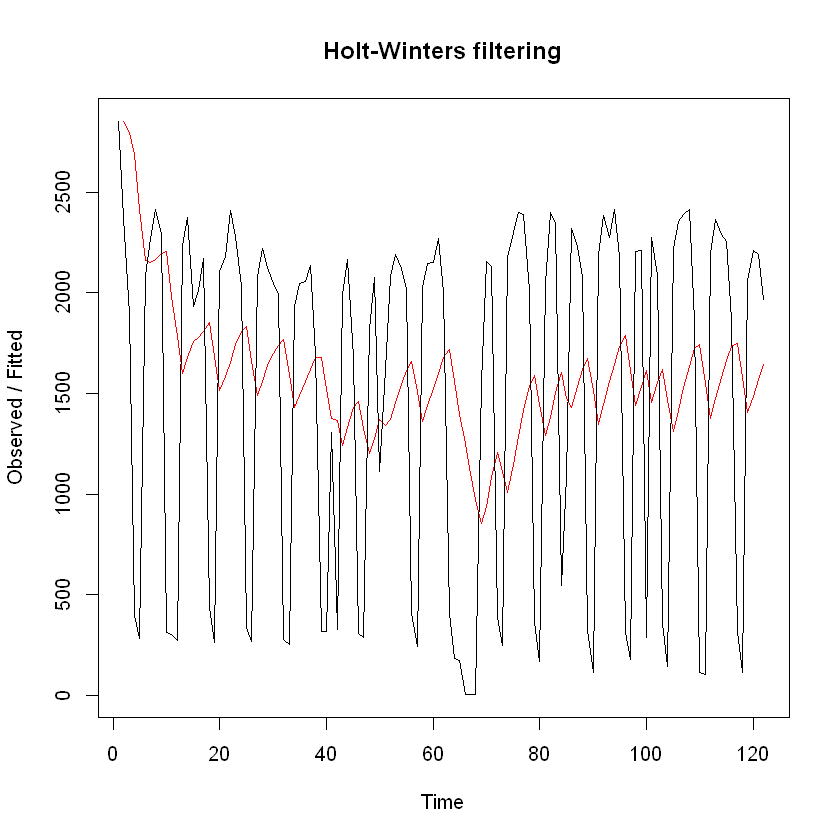

In [58]:
plot(siwim_data.ts.ses)

### Holt winters forecast (beta = 0, no seasonal component)

In [70]:
siwim_data.ts.Forecasts <- HoltWinters(siwim_data.ts.days,
                                       gamma = FALSE)
siwim_data.ts.Forecasts

Holt-Winters exponential smoothing with trend and without seasonal component.

Call:
HoltWinters(x = siwim_data.ts.days, gamma = FALSE)

Smoothing parameters:
 alpha: 1
 beta : 0.03108672
 gamma: FALSE

Coefficients:
         [,1]
a 1966.000000
b    1.627391

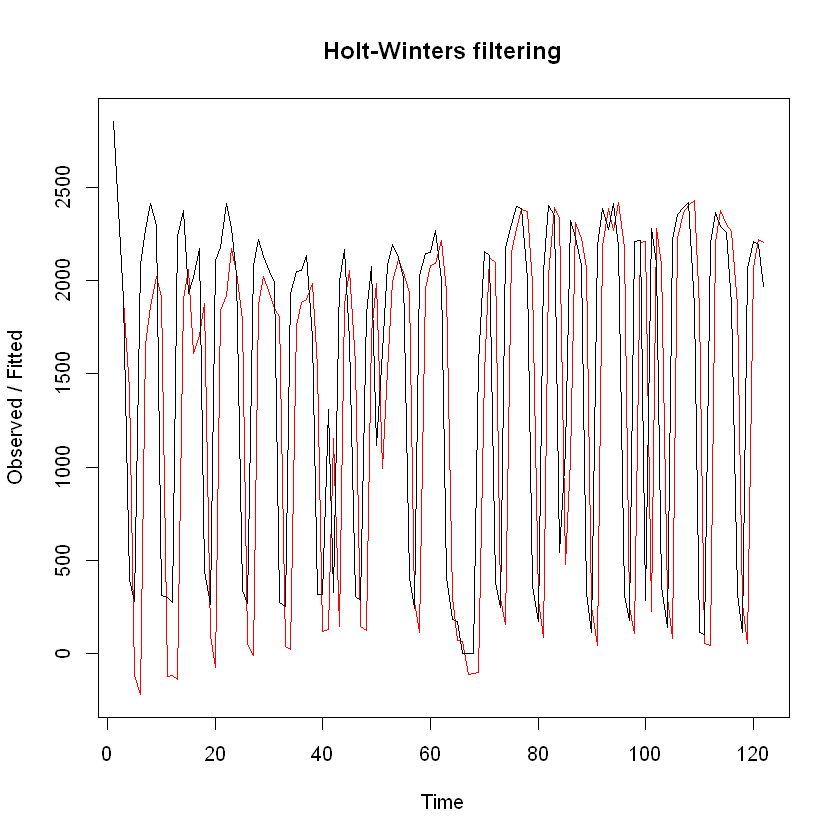

In [71]:
plot(siwim_data.ts.Forecasts)

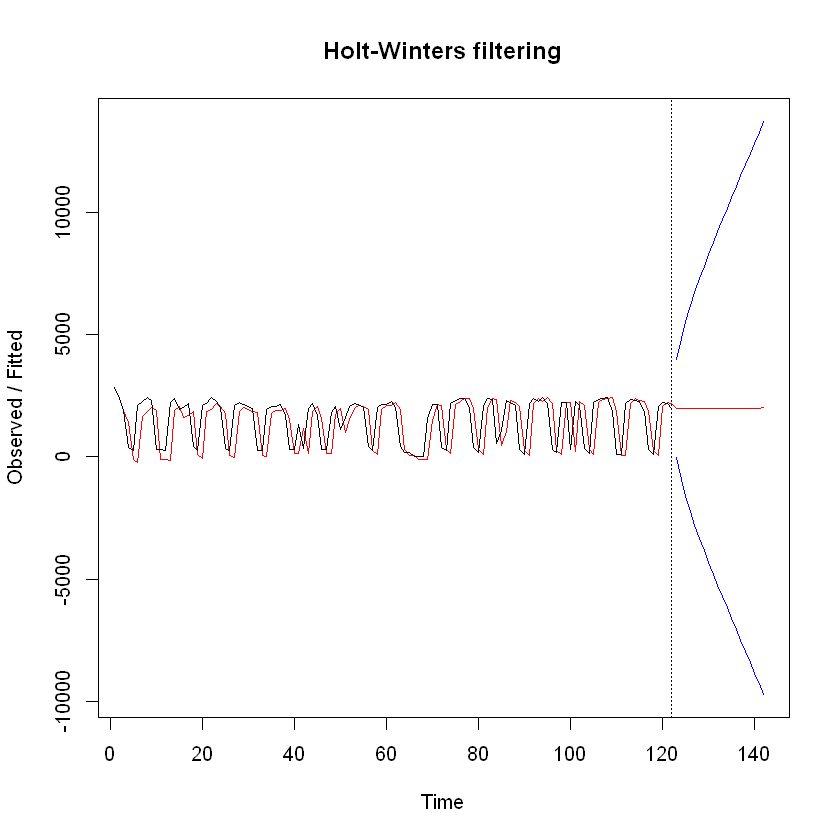

In [79]:
plot(siwim_data.ts.Forecasts, predict(siwim_data.ts.Forecasts, 20, prediction.interval = TRUE) )

## 10. Other times series exploration

In [84]:
siwim_daily_freq <- siwim_data[, .N, by = Date]
siwim_daily_freq.zoo <- zoo(siwim_daily_freq$N,  as.Date(siwim_daily_freq$Date, format = "%Y-%m-%d"))

In [85]:
head(siwim_daily_freq.zoo)

2017-07-04 2017-07-05 2017-07-06 2017-07-07 2017-07-08 2017-07-09 
      2852       2372       1895        397        280       2086 

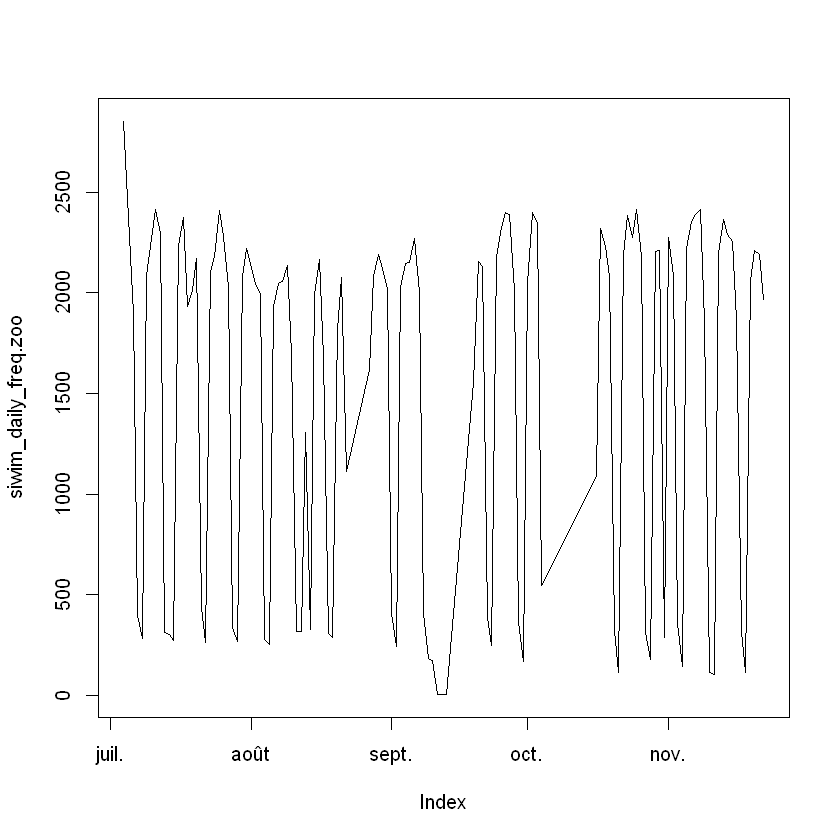

In [86]:
plot(siwim_daily_freq.zoo)

In [87]:
auto.arima(siwim_daily_freq.zoo)

Series: siwim_daily_freq.zoo 
ARIMA(2,0,2) with non-zero mean 

Coefficients:
         ar1      ar2      ma1      ma2       mean
      0.7715  -0.3883  -0.2133  -0.3267  1499.5986
s.e.  0.1424   0.1282   0.1554   0.1454    51.3561

sigma^2 estimated as 442186:  log likelihood=-974.99
AIC=1961.97   AICc=1962.6   BIC=1979.71

In [88]:
siwim_data.irts <- irts(siwim_data$Timestamp, cbind(siwim_data$V1 ,siwim_data$MGV))

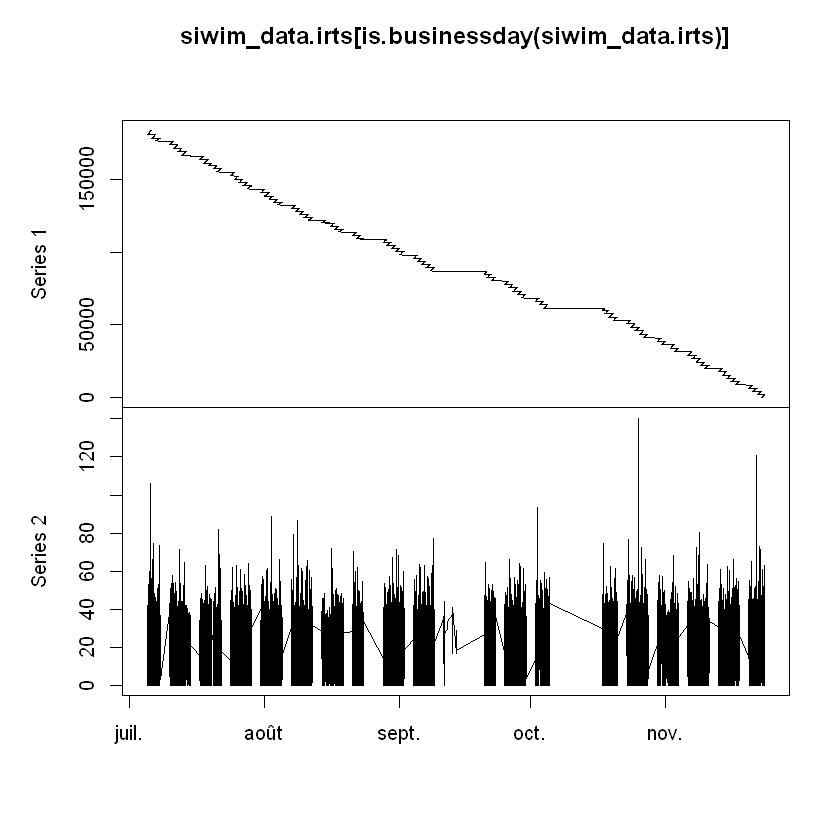

In [89]:
plot(siwim_data.irts[is.businessday(siwim_data.irts)])

In [90]:
year(as.Date(min(siwim_daily_freq$Date)))

[1] 2017

In [91]:
c(year(min_date),month(min_date), day(min_date))

ERROR: Error in as.POSIXlt(x): objet 'min_date' introuvable


In [92]:
min_date <- min(siwim_daily_freq$Date)
max_date <- max(siwim_daily_freq$Date)
siwim_daily_freq.ts = ts(siwim_daily_freq$N, 
                         start = c(year(min_date),month(min_date), day(min_date)), 
                         end = c(year(max_date),month(max_date), day(max_date)), deltat = 1/365)

ERROR: Error in day(min_date): impossible de trouver la fonction "day"


In [93]:
print(siwim_daily_freq.ts)

ERROR: Error in print(siwim_daily_freq.ts): objet 'siwim_daily_freq.ts' introuvable


In [94]:
daily <- msts(siwim_daily_freq$N, seasonal.periods=c(7,365.25))

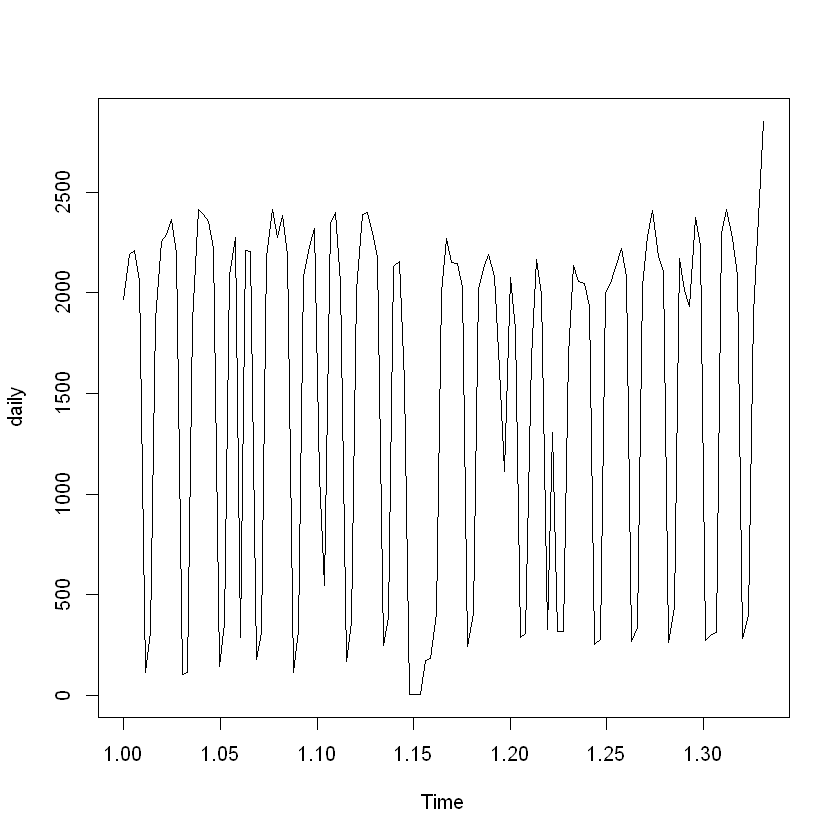

In [95]:
plot(daily)

In [96]:
fit <- tbats(daily)
fc <- forecast(tbats, na.remove)

Warning message in mean.default(x, na.rm = TRUE):
"argument is not numeric or logical: returning NA"

ERROR: Error in x - fits: argument non numérique pour un opérateur binaire


In [ ]:
stl(ts(as.numeric(siwim_daily_freq$N), frequency=52), s.window="periodic", robust=TRUE) 